In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

In [14]:
hours = np.arange(0,25,1)
share = [0.0010, 0.0010, 0.0010, 0.0020, 0.0050, 0.0150, 0.0501, 0.1022, 0.0581, 0.0411, 0.0481, 0.0571, 0.0571,
               0.0521, 0.0651, 0.0982, 0.0852, 0.0832, 0.0651, 0.0451, 0.0301, 0.0220, 0.0100, 0.0050, 0]

In [15]:
hours

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [16]:
points = 600 * 24

In [63]:
xs = np.linspace(0, 24, points)
f2 = interp1d(hours, share, kind='cubic')
ys = f2(xs)
ys = ys / sum(ys)

In [64]:
trips_am_matrix, trips_md_matrix, trips_pm_matrix, trips_ov_matrix = 3341685, 6630652, 6128536, 3202484
trips_daily_matrix = trips_am_matrix+trips_md_matrix+trips_pm_matrix+trips_ov_matrix
trips_am = (np.sum(ys[np.where((xs>=6) & (xs<9))]) * trips_daily_matrix).astype(int)
trips_md = (np.sum(ys[np.where((xs>=9) & (xs<15))]) * trips_daily_matrix).astype(int)
trips_pm = (np.sum(ys[np.where((xs>=15) & (xs<19))]) * trips_daily_matrix).astype(int)
trips_ov = (np.sum(ys[np.where((xs>=19) & (xs<24) | (xs>=0) & (xs<6))]) * trips_daily_matrix).astype(int)

### DT Generator Class

In [93]:
class DTGenerator:
    def __init__(self, x, prob, seed=0, interp=0):
        """

        :param x:      x values for the probability density
        :param prob:   probabilities
        :param seed:   random seed
        :param interp: number of interpolation points
        """
        self._prob = prob
        self._x = x
        self._seed = seed
        self._interp = interp

        if len(x) != len(prob):
            raise ValueError("The lengths of input distribution do not match")

        self._prob_interp = prob
        if interp:
            self._x_interp = np.linspace(x[0], x[-1], self._interp)
            interpolator = interp1d(self._x, self._prob, kind='cubic')
            self._prob_interp = interpolator(self._x_interp)
            self._prob_interp = self._prob_interp / sum(self._prob_interp)
        else:
            self._x_interp = self._x

        np.random.seed(self._seed)

    def _select_range(self, period=None):
        if period:
            selector = np.array([False]*len(self._x_interp))
            for p in period:
                selector = selector | ((self._x_interp >= p[0]) & (self._x_interp < p[1]))

            xs = self._x_interp[selector]
            probs = self._prob_interp[selector]
            probs = probs / np.sum(probs)
            return probs, xs
        return self._prob_interp, self._x_interp

    def dt(self, period, size=1):
        probs, xs = self._select_range(period)
        return np.random.choice(xs, p=probs, size=size)

In [98]:
dt_gen = DTGenerator(x=hours, prob=share, interp=points, seed=42)

In [106]:
# trips = [3341685, 6630652, 6128536, 3202484]
trips = [trips_am, trips_md, trips_pm, trips_ov]
periods = [[(6,9)], [(9,15)], [(15,19)], [(0,6),(19,24)]]

In [107]:
start = time.clock()
departure_times = np.array([])
for trip, period in zip(trips, periods):
    departure_times = np.concatenate([departure_times,dt_gen.dt(period, trip)])
end = time.clock()
print("Total Processing Time = {0:.2f}".format(end-start))

Total Processing Time = 2.29


In [108]:
departure_times[0], len(departure_times)

(6.185429543718314, 19303355)

In [109]:
hist, bin_edges = np.histogram(departure_times, bins=dt_gen._x_interp, density=False)
hist = hist / sum(hist)

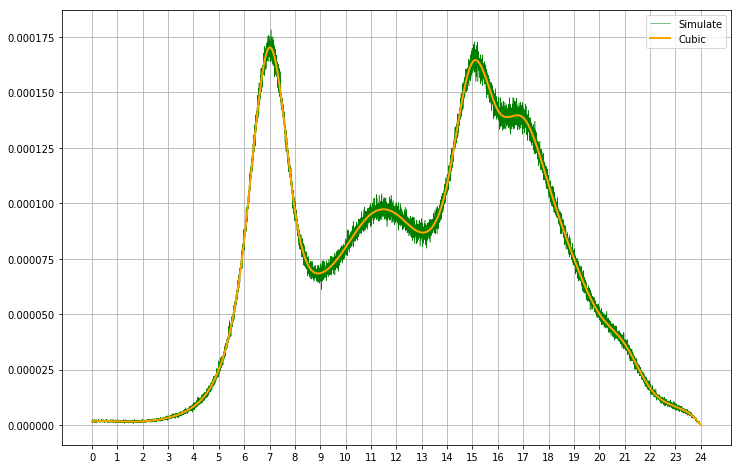

In [110]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(bin_edges[:-1], hist, color='green', linewidth=0.5, label='Simulate')
ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)
ax.legend()

### Simulation using daily curve
Random sampling from the daily curve but keep the period totals by using rejection sampling. 
Draw samples until the desired size is met. 

In [44]:
trips_am_matrix, trips_md_matrix, trips_pm_matrix, trips_ov_matrix = 3341685, 6630652, 6128536, 3202484
trips_daily_matrix = trips_am_matrix+trips_md_matrix+trips_pm_matrix+trips_ov_matrix
trips_am = (np.sum(ys[np.where((xs>=6) & (xs<9))]) * trips_daily_matrix).astype(int)
trips_md = (np.sum(ys[np.where((xs>=9) & (xs<15))]) * trips_daily_matrix).astype(int)
trips_pm = (np.sum(ys[np.where((xs>=15) & (xs<19))]) * trips_daily_matrix).astype(int)
trips_ov = (np.sum(ys[np.where((xs>=19) & (xs<24) | (xs>=0) & (xs<6))]) * trips_daily_matrix).astype(int)

In [223]:
departure_times = []
sample_size = trips_daily_matrix
for s in range(sample_size):  
    index = np.random.choice(np.arange(len(xs)), p=ys)
    if index >= len(xs) - 1:
        selected_time = np.random.uniform(23, 24, size=1)[0]
    else:
        start_time, end_time = xs[index], xs[index + 1]
        selected_time = np.random.uniform(start_time, end_time, size=1)[0]
    departure_times.append(selected_time)

In [211]:
# hist, bin_edges = np.histogram(departure_times, bins=np.linspace(0,23,points), density=False)
# hist = hist / sum(hist)

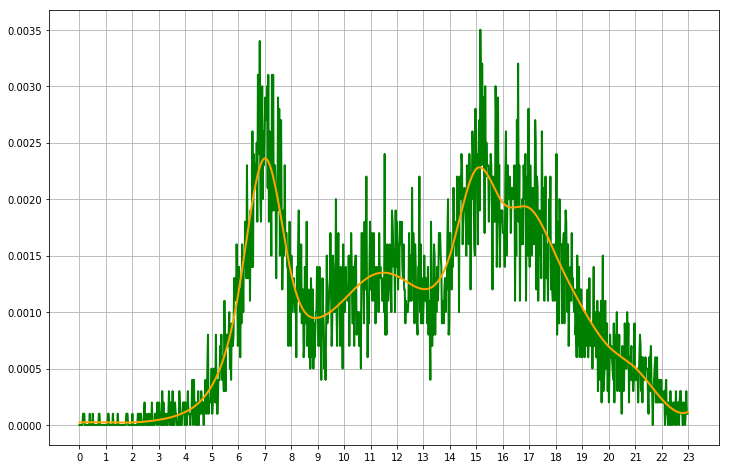

In [213]:
# fig, ax = plt.subplots(figsize=(12,8))
# # ax.plot(hours, share, color='blue', linewidth=2, label='Linear')
# ax.plot(bin_edges[:-1], hist, color='green', linewidth=2, label='Simulate')
# ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
# ax.set_xticks(hours)
# ax.set_xticklabels(hours)
# ax.grid(True)

### Simulation by daily curve
Without random distribution between sampling points

In [73]:
sample_size = 10000000
departure_times = np.random.choice(xs, p=ys, size=sample_size)

In [74]:
hist, bin_edges = np.histogram(departure_times, bins=xs, density=False)
hist = hist / sum(hist)

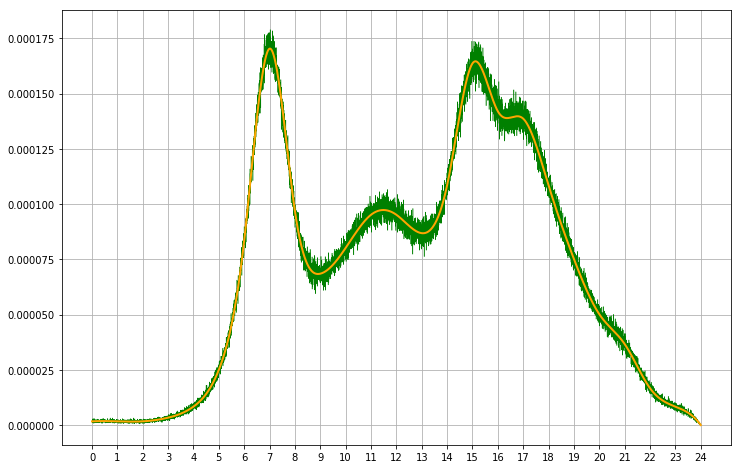

In [75]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(hours, share, color='blue', linewidth=2, label='Linear')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=0.5, label='Simulate')
ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

### Simulation by breaking down daily samples

In [54]:
sample_size = 10000000
departure_times = np.random.choice(xs, p=ys, size=sample_size)

In [55]:
departure_am = departure_times[np.where((departure_times >= 6) & (departure_times < 9))]
departure_md = departure_times[np.where((departure_times >= 9) & (departure_times < 15))]
departure_pm = departure_times[np.where((departure_times >= 15) & (departure_times < 19))]
departure_ov = departure_times[np.where((departure_times >= 19) & (departure_times < 24) | (departure_times >= 0) & (departure_times < 6))]                                        

In [56]:
samples_am = np.random.choice(departure_am, replace=True, size=trips_am_matrix)
samples_md = np.random.choice(departure_md, replace=True, size=trips_md_matrix)
samples_pm = np.random.choice(departure_pm, replace=True, size=trips_pm_matrix)
samples_ov = np.random.choice(departure_ov, replace=True, size=trips_ov_matrix)

In [57]:
samples_daily = np.concatenate((samples_am, samples_md, samples_pm, samples_ov))

In [58]:
hist, bin_edges = np.histogram(samples_daily, bins=xs, density=False)
hist = hist / sum(hist)

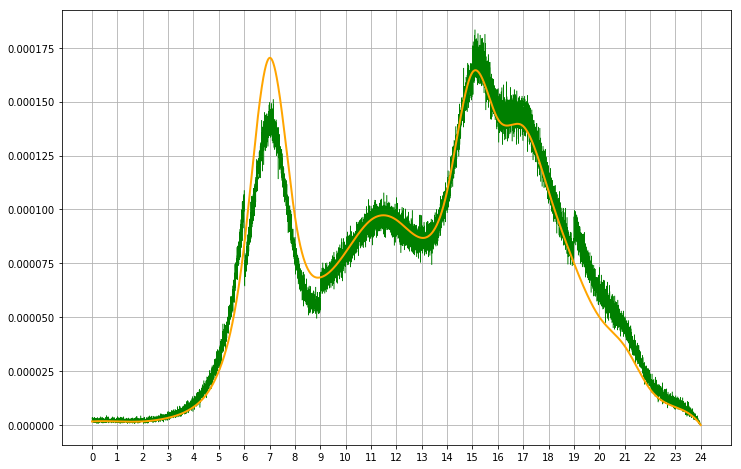

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(hours, share, color='blue', linewidth=2, label='Linear')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=0.5, label='Simulate')
ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

In [ ]:
trips_daily = trips_am+trips_md+trips_pm+trips_ov
trips_am *1.0/trips_daily, trips_md *1.0/trips_daily, trips_pm *1.0/trips_daily, trips_ov *1.0/trips_daily

### Simulation by time periods

For each period, draw a random sample of size 5,000,000


In [45]:
period_def = {'am': [(6, 9)], 'md': [(9, 15)], 'pm': [(15, 19)], 'ov': [(0, 6), (19, 24)]}

In [46]:
def get_period_share(period, tod_times, tod_shares):
    """

    :param period: a list of tuples specifying period start and end times
    :param tod_times:
    :param tod_shares:
    :return:
    """
    
    share = []
    times = []
    for p in period:
        for t, s in zip(tod_times, tod_shares):
            if p[0] <= t < p[1]:
                share.append(s)
                times.append(t)
    
    # normalize the share
    share = [s/sum(share) for s in share]
    return share, times

In [47]:
def get_departures(period, tod_times, tod_shares, size=1000):
    """
    :param period: a list of tuples specifying period start and end times
    :param tod_times: a list of at least 24 times. should be daily diurnal from 0 to 24

    """
    # Do the interpolation
    if len(tod_times) < 600*24:
        f = interp1d(tod_times, tod_shares, kind='cubic')
        tod_times = np.linspace(0, max(tod_times), 600*24)
        tod_shares = f(tod_times)

    shares, times = get_period_share(period, tod_times, tod_shares)
    return np.random.choice(times, p=shares, size=size)
    

In [48]:
departure_times = []
sample_sizes = [trips_am, trips_md, trips_pm, trips_ov]
# sample_size = 10
for p, sample_size in zip(period_def.keys(), sample_sizes):   
    print("Processing period {0:s}".format(p))
    dt = get_departures(period_def[p], hours, share, size=sample_size)
    departure_times.append(dt)
departure_times = np.concatenate(departure_times)

Processing period am
Processing period md
Processing period pm
Processing period ov


In [49]:
min(departure_times), max(departure_times)

(0.0, 23.99666643516911)

In [50]:
hist, bin_edges = np.histogram(departure_times, bins=xs, density=False)

In [51]:
max(hist), sum(hist)

(3400, 19303355)

In [52]:
hist = hist / np.sum(hist)

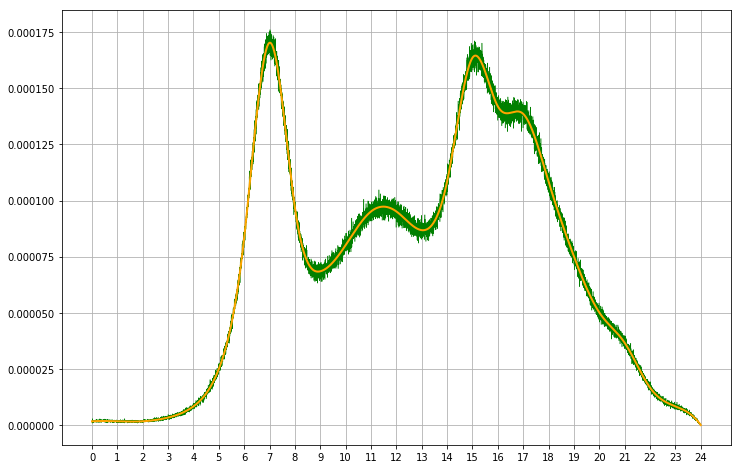

In [53]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(hours, share, color='blue', linewidth=2, label='Linear')
ax.plot(bin_edges[:-1], hist, color='green', linewidth=0.5, label='Simulate')
ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

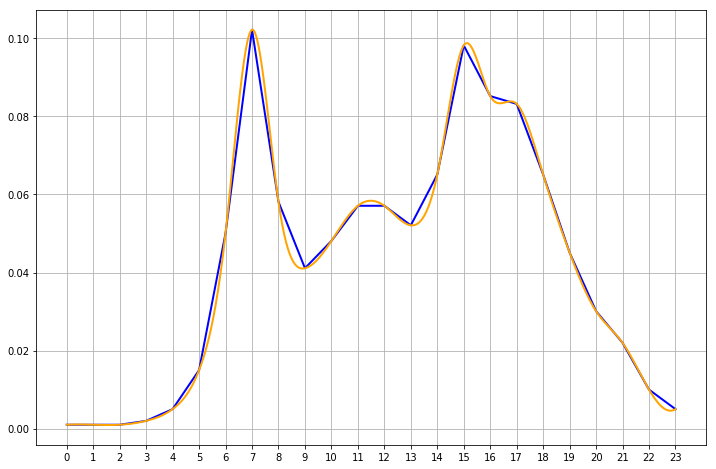

In [178]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(hours, share, color='blue', linewidth=2, label='Linear')
ax.plot(xs, ys, color='orange', linewidth=2, label='Cubic')
# ax.plot(bin_edges[:-1], hist, color='green', linewidth=2, label='Simulate')
ax.set_xticks(hours)
ax.set_xticklabels(hours)
ax.grid(True)

In [ ]:
a = np